In [ ]:
# !pip install torchviz

In [ ]:
import os
import math

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset,random_split

import torchvision.models as models
from torchsummary import summary
from sklearn.metrics import accuracy_score
from PIL import Image
#from torchviz import make_dot
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
!unzip "/content/drive/MyDrive/Deep_learning_music_project/gender_recognition_preprocessed_data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: gender_recognition_preprocessed_data/labels/8_0_22_0.npy  
  inflating: gender_recognition_preprocessed_data/labels/8_0_22_1.npy  
  inflating: gender_recognition_preprocessed_data/labels/8_0_22_10.npy  
  inflating: gender_recognition_preprocessed_data/labels/8_0_22_11.npy  
  inflating: gender_recognition_preprocessed_data/labels/8_0_22_12.npy  
  inflating: gender_recognition_preprocessed_data/labels/8_0_22_13.npy  
  inflating: gender_recognition_preprocessed_data/labels/8_0_22_14.npy  
  inflating: gender_recognition_preprocessed_data/labels/8_0_22_15.npy  
  inflating: gender_recognition_preprocessed_data/labels/8_0_22_16.npy  
  inflating: gender_recognition_preprocessed_data/labels/8_0_22_17.npy  
  inflating: gender_recognition_preprocessed_data/labels/8_0_22_18.npy  
  inflating: gender_recognition_preprocessed_data/labels/8_0_22_19.npy  
  inflating: gender_recognition_preprocessed_data/labels/8_0_22_2.npy  
  i

In [ ]:
BATCH_SIZE=5

In [ ]:
class MFCDataset(Dataset):
  def __init__(self,base_folder):
    self.all_images_path = os.listdir(base_folder+"/images")
    self.base_folder = base_folder
# __len__ function returns the number of samples in our dataset.
  def __len__(self):
    return len(self.all_images_path)

  def __getitem__(self,index):
    img_path = self.base_folder + "/images/" +self.all_images_path[index]
    img = Image.open(img_path)
    image = torch.reshape( torch.tensor(np.array(img,dtype="float32")), (3,224,224) )

    label_path = self.base_folder + "/labels/" +self.all_images_path[index][:-4] + ".npy"
    label=np.load(label_path,allow_pickle=True)
    number_label = torch.tensor(label[0],dtype=torch.float32)
    gender_label = torch.tensor(label[1],dtype=torch.float32)

    return (image,number_label,gender_label)

In [ ]:
dataset = MFCDataset("/content/gender_recognition_preprocessed_data")

In [ ]:
train_dataset,test_dataset = random_split(dataset,[math.ceil(0.7*len(dataset)),math.floor(0.3*len(dataset))])

In [ ]:
train_dataloader  = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)


In [ ]:
data_iter = iter(train_dataloader)

In [ ]:
example = next(data_iter)

In [ ]:
example[0].shape

torch.Size([5, 3, 224, 224])

##Now lets define the model

### FUll model (Multi-task learning model)

In [ ]:
resnet = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
input = torch.rand(5,3,224,224).to(device)
print(input.dtype)
print(input.shape)

torch.float32
torch.Size([5, 3, 224, 224])


In [ ]:
class ModifiedResNet(nn.Module):
            def __init__(self):
                super(ModifiedResNet, self).__init__()
                self.features = nn.Sequential(
                    #remove last fully connected layer
                    *list(resnet.children())[:-1]
                )
                self.dense1 = nn.Linear(512,128)
                self.dense_number = nn.Linear(128,10)
                self.dense_gender = nn.Linear(128,1)
            def forward(self, x):
              # input shape = batch_size,n_channels,height,width
                x = self.features(x) # output shape = batch_size * 512 * 1 * 1
                x = x.view(-1,512)
                x = nn.ReLU()(self.dense1(x)) # ouput shape = batch_size * 128
                number_pred = nn.Softmax()(self.dense_number(x))
                gender_pred = nn.Sigmoid()(self.dense_gender(x))

                return [number_pred,gender_pred]

In [ ]:
model = ModifiedResNet()
model = model.to(device)

In [ ]:
summary(model, (3, 224, 224),batch_size=5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [5, 64, 112, 112]           9,408
       BatchNorm2d-2          [5, 64, 112, 112]             128
              ReLU-3          [5, 64, 112, 112]               0
         MaxPool2d-4            [5, 64, 56, 56]               0
            Conv2d-5            [5, 64, 56, 56]          36,864
       BatchNorm2d-6            [5, 64, 56, 56]             128
              ReLU-7            [5, 64, 56, 56]               0
            Conv2d-8            [5, 64, 56, 56]          36,864
       BatchNorm2d-9            [5, 64, 56, 56]             128
             ReLU-10            [5, 64, 56, 56]               0
       BasicBlock-11            [5, 64, 56, 56]               0
           Conv2d-12            [5, 64, 56, 56]          36,864
      BatchNorm2d-13            [5, 64, 56, 56]             128
             ReLU-14            [5, 64,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

21351755

In [ ]:
help(summary)

Help on function summary in module torchsummary.torchsummary:

summary(model, input_size, batch_size=-1, device='cuda')



In [ ]:
print(model(input)[0].shape)
print(model(input)[1].shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


torch.Size([5, 10])
torch.Size([5, 1])


## now lets define the training loop

In [ ]:
# Binary-cross entropy loss, closely related to logistic regression loss
gender_obj_fn = nn.BCELoss()

#
number_obj_fn = nn.CrossEntropyLoss()

# Adam Optimizer, learning rate 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.)

In [ ]:
training_loss_history = []
val_number_acc_history = []
val_gender_acc_history = []
val_loss_history = []
num_epochs = 100 # the number of training epoch (i.e. when you've gone through all samples of the training data, that's one epoch)
evaluate_every_epoch = 1 # how often you want to evaluate the network during training?
best_number_acc = 0.0 # for keeping track of the best accuracy on the validation data
best_gender_acc = 0.0 # for keeping track of the best accuracy on the validation data

In [ ]:
def training_step(dataloader,include_number = True, include_gender = True):
  avg_number_pred_loss=0
  avg_gneder_pred_loss=0
  for batch_idx,(img,number_label,gender_label) in enumerate(dataloader):
    img,number_label,gender_label = img.to(device), number_label.to(device),gender_label.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    if include_number and include_gender:
        number_pred,gender_pred = model(img)
        loss_number = number_obj_fn(number_pred, number_label)
        loss_gender = gender_obj_fn(torch.squeeze(gender_pred), gender_label)

        loss = loss_number + loss_gender
    elif include_number:
        number_pred = model(img)
        loss_number = number_obj_fn(number_pred, number_label)
        loss_gender = 0
        loss = loss_number + loss_gender
    elif include_gender:
        gender_pred = model(img)
        loss_number = 0
        loss_gender = gender_obj_fn(torch.squeeze(gender_pred), gender_label)

        loss = loss_number + loss_gender

    loss.backward()
    optimizer.step()

    # log the losses
    avg_gneder_pred_loss+=loss_gender
    avg_number_pred_loss+=loss_number

  avg_number_pred_loss/= len(dataloader.dataset)
  avg_gneder_pred_loss/= len(dataloader.dataset)

  return (avg_number_pred_loss+avg_gneder_pred_loss,avg_number_pred_loss,avg_gneder_pred_loss)
  

In [ ]:
def evaluate(dataloader,include_number=True,include_gender=True):
  loss_number=0
  loss_gender=0
  correct_gender_pred=0
  correct_number_pred=0
  for batch_idx,(img,number_label,gender_label) in enumerate(dataloader):
    img,number_label,gender_label = img.to(device), number_label.to(device),gender_label.to(device)

    with torch.no_grad():
        if include_number and include_gender:
            number_pred,gender_pred = model(img)
        elif include_number:
            number_pred = model(img)
        elif include_gender:
            gender_pred = model(img)

    if include_number and include_gender:
        loss_number += number_obj_fn(number_pred, number_label)
        loss_gender += gender_obj_fn(torch.squeeze(gender_pred), gender_label)
    elif include_number:
        loss_number += number_obj_fn(number_pred, number_label)
        loss_gender += 0
    elif include_gender:
        loss_number += 0
        loss_gender += gender_obj_fn(torch.squeeze(gender_pred), gender_label)
    
    #
    if include_gender:
        gender_pred[gender_pred >= 0.5] = 1.
        gender_pred[gender_pred < 0.5] = 0.
        correct_gender_pred += torch.sum(gender_pred.view(5) == gender_label)
    #
    if include_number:
        number_pred = torch.argmax(number_pred,axis=1)
        number_label = torch.argmax(number_label,axis=1)
        correct_number_pred+=torch.sum(number_pred==number_label)
    #

  loss_number/=len(dataloader.dataset)
  loss_gender/=len(dataloader.dataset)

  number_acc = correct_number_pred/len(dataloader.dataset)
  gender_acc = correct_gender_pred/len(dataloader.dataset)
  
  return (number_acc,gender_acc,loss_number+loss_gender)

In [ ]:
best_model_path = "/content/drive/MyDrive/Deep_learning_music_project/best_model_both_gender_number_recognition"
best_gender_model_path = "/content/drive/MyDrive/Deep_learning_music_project/best_model_gender_gender_number_recognition"
best_number_model_path = "/content/drive/MyDrive/Deep_learning_music_project/best_model_number_gender_number_recognition"

In [ ]:
def train(best_model_path=best_model_path,best_number_model_path=best_number_model_path,best_gender_model_path = best_gender_model_path,include_gender = True,include_number=True):
    multi_task = include_gender and include_number
    training_loss_history = []
    val_number_acc_history = []
    val_gender_acc_history = []
    val_loss_history = []
    num_epochs = 10 # the number of training epoch (i.e. when you've gone through all samples of the training data, that's one epoch)
    evaluate_every_epoch = 1 # how often you want to evaluate the network during training?
    best_number_acc = 0.0 # for keeping track of the best accuracy on the validation data
    best_gender_acc = 0.0 # for keeping track of the best accuracy on the validation data
    print("Training starting ... ")
    print()
    for epoch in range(num_epochs):
        print("Epoch number {} --------------------------------------------------".format(epoch+1))
        avg_total_loss,avg_number_pred_loss,avg_gener_pred_loss = training_step(train_dataloader,include_gender = include_gender,include_number=include_number)
        training_loss_history.append(avg_total_loss)
        print(" Average total loss = {} \n Average number prediction loss = {} \n Average gender prediction loss = {} ".format(avg_total_loss,avg_number_pred_loss,avg_gener_pred_loss))
        if ((epoch+1)%evaluate_every_epoch)==0:
            print("performing validation ----------------------------------------")
            eval_number_acc,eval_gender_acc,eval_loss = evaluate(test_dataloader,include_gender = include_gender,include_number=include_number)
            val_number_acc_history.append(eval_number_acc)
            val_gender_acc_history.append(eval_gender_acc)
            val_loss_history.append(eval_loss)
            print(" number accuracy = {} \n gender accuracy = {} \n Average val  loss = {} ".format(eval_number_acc,eval_gender_acc,eval_loss))
            #if the best validation performance so far, save the network to file
            if eval_number_acc > best_number_acc and eval_gender_acc > best_gender_acc and multi_task:
                print("Saving best model (for both tasks)")
                torch.save(model.state_dict(), best_model_path)
                best_number_acc = eval_number_acc
                best_gender_acc = eval_gender_acc
            elif eval_number_acc > best_number_acc:
                print("Saving best Number prediction model")
                torch.save(model.state_dict(),best_number_model_path)
                best_number_acc = eval_number_acc
            elif eval_gender_acc > best_gender_acc:
                print("Saving best gender prediction model")
                torch.save(model.state_dict(), best_gender_model_path)
                best_gender_acc = eval_gender_acc

    return (training_loss_history,val_number_acc_history,val_gender_acc_history,val_loss_history)

In [ ]:
train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Training starting ... 

Epoch number 1 --------------------------------------------------
 Average total loss = 0.4621013402938843 
 Average number prediction loss = 0.38512805104255676 
 Average gender prediction loss = 0.07697328925132751 
performing validation ----------------------------------------
 number accuracy = 0.7296666502952576 
 gender accuracy = 0.8804444670677185 
 Average val  loss = 0.4030790627002716 
Saving best model (for both tasks)
Epoch number 2 --------------------------------------------------
 Average total loss = 0.37223345041275024 
 Average number prediction loss = 0.32536157965660095 
 Average gender prediction loss = 0.04687187075614929 
performing validation ----------------------------------------
 number accuracy = 0.9092222452163696 
 gender accuracy = 0.9317777752876282 
 Average val  loss = 0.3456738591194153 
Saving best model (for both tasks)
Epoch number 3 --------------------------------------------------
 Average total loss = 0.337893426418304

In [ ]:
training_loss_history = [0.4621013402938843, 0.37223345041275024 , 0.33789342641830444 , 0.3227865993976593  , 0.31449201703071594 , 0.309646874666214 , 0.3055521547794342 , 0.3046237528324127 , 0.30235257744789124 , 0.30128517746925354 , 0.2998110055923462 , 0.2992246150970459 , 0.29824310541152954  , 0.2977754771709442 , 0.2971668541431427 ,0.296993225812912 , 0.29651790857315063 , 0.2962014675140381  ]
number_acc_history = [0.7296666502952576, 0.9092222452163696 , 0.9620000123977661 , 0.9682222604751587 , 0.9665555953979492 , 0.9632222056388855 , 0.9778888821601868 , 0.9854444265365601 , 0.9831111431121826  , 0.9824444651603699  , 0.9842222332954407 , 0.987666666507721 , 0.9908888936042786 , 0.992555558681488 , 0.9924444556236267 , 0.9923333525657654 , 0.9903333187103271 , 0.9921111464500427  ]
gender_acc_history = [0.8804444670677185 , 0.9317777752876282,0.9661111235618591 , 0.9665555953979492 , 0.9687777757644653 , 0.9715555906295776 , 0.9796666502952576 , 0.9738888740539551 , 0.9834444522857666 , 0.9796666502952576  , 0.9845555424690247, 0.9784444570541382  , 0.983222246170044 , 0.9837777614593506 , 0.9857777953147888 , 0.9890000224113464  , 0.9848889112472534 , 0.9892222285270691 ]
val_loss_history = [0.4030790627002716, 0.3456738591194153, 0.3208194673061371  , 0.31724607944488525 , 0.31627580523490906 , 0.3163527250289917 , 0.30839473009109497 , 0.31112757325172424 , 0.3058256208896637 , 0.3079991638660431 , 0.3049226701259613 , 0.30804261565208435  , 0.3046853542327881  ,0.30427688360214233 , 0.30227688360214233 , 0.30115094780921936 , 0.30410802364349365 , 0.30165615677833557 ]


Text(0.5, 1.0, 'ResNet based model training and validation loss (multitask)')

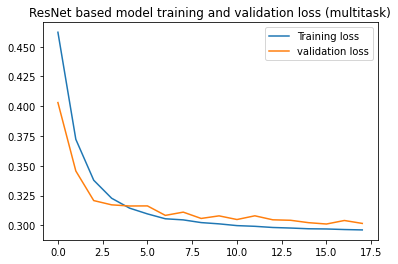

In [ ]:
plt.plot(training_loss_history,label="Training loss")
plt.plot(val_loss_history,label = "validation loss")
plt.legend()
plt.title("ResNet based model training and validation loss (multitask)")

Text(0.5, 1.0, 'Resnet based model Number and Gender prediction accuracy in validation set')

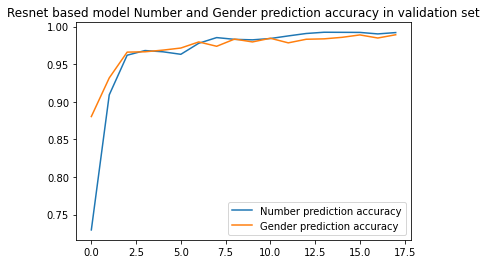

In [ ]:
plt.plot(number_acc_history,label="Number prediction accuracy")
plt.plot(gender_acc_history,label= "Gender prediction accuracy")
plt.legend()
plt.title("Resnet based model Number and Gender prediction accuracy in validation set")

### Number classification model resnet

In [ ]:
resnet = models.resnet34(pretrained=True)
class ModifiedResNetNumber(nn.Module):
            def __init__(self):
                super(ModifiedResNetNumber, self).__init__()
                self.features = nn.Sequential(
                    #remove last fully connected layer
                    *list(resnet.children())[:-1]
                )
                self.dense1 = nn.Linear(512,128)
                self.dense_number = nn.Linear(128,10)
            def forward(self, x):
              # input shape = batch_size,n_channels,height,width
                x = self.features(x) # output shape = batch_size * 512 * 1 * 1
                x = x.view(-1,512)
                x = nn.ReLU()(self.dense1(x)) # ouput shape = batch_size * 128
                number_pred = nn.Softmax()(self.dense_number(x))
                return number_pred

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
model = ModifiedResNetNumber()
model = model.to(device)

In [ ]:
# Binary-cross entropy loss, closely related to logistic regression loss
gender_obj_fn = nn.BCELoss()

#
number_obj_fn = nn.CrossEntropyLoss()

# Adam Optimizer, learning rate 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.)

In [ ]:
best_model_path = None
best_gender_model_path = None
best_number_model_path = "/content/drive/MyDrive/Deep_learning_music_project/best_model_number_number_recognition"

In [ ]:
training_loss_history,val_number_acc_history,val_gender_acc_history,val_loss_history = train(best_model_path=best_model_path,best_number_model_path=best_number_model_path,best_gender_model_path=best_gender_model_path,include_gender= False)

Training starting ... 

Epoch number 1 --------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


 Average total loss = 0.3924155533313751 
 Average number prediction loss = 0.3924155533313751 
 Average gender prediction loss = 0.0 
performing validation ----------------------------------------
 number accuracy = 0.7527778148651123 
 gender accuracy = 0.0 
 Average val  loss = 0.34190526604652405 
Saving best Number prediction model
Epoch number 2 --------------------------------------------------
 Average total loss = 0.33477848768234253 
 Average number prediction loss = 0.33477848768234253 
 Average gender prediction loss = 0.0 
performing validation ----------------------------------------
 number accuracy = 0.8450000286102295 
 gender accuracy = 0.0 
 Average val  loss = 0.32305434346199036 
Saving best Number prediction model
Epoch number 3 --------------------------------------------------
 Average total loss = 0.3162122070789337 
 Average number prediction loss = 0.3162122070789337 
 Average gender prediction loss = 0.0 
performing validation -------------------------------

In [ ]:
training_loss_history = [0.3924155533313751 , 0.33477848768234253 , 0.3162122070789337  , 0.30860406160354614 , 0.30495405197143555 , 0.30226531624794006 , 0.3013612926006317 , 0.2997465431690216 , 0.2994210720062256,0.2986855208873749  ]
number_acc_history = [0.7527778148651123 , 0.8450000286102295 , 0.8911111354827881 , 0.906000018119812 ,0.9416666626930237  , 0.951888918876648 , 0.9481111168861389 , 0.961222231388092 , 0.972444474697113 , 0.9570000171661377 ] 
val_loss_history = [0.34190526604652405 , 0.32305434346199036 , 0.3138832747936249  , 0.3111582398414612 , 0.303878515958786 , 0.30183255672454834 ,0.30262625217437744  , 0.2999823987483978 , 0.297753244638443 , 0.30082598328590393]


Text(0.5, 1.0, 'Resnet model training and validation loss (number prediction)')

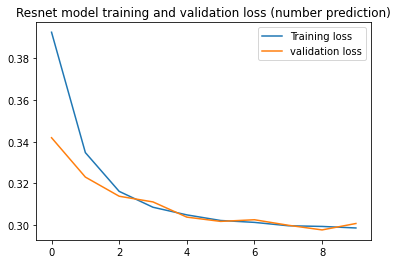

In [ ]:
plt.plot(training_loss_history,label="Training loss")
plt.plot(val_loss_history,label = "validation loss")
plt.legend()
plt.title("Resnet model training and validation loss (number prediction)")

Text(0.5, 1.0, 'Resnet based model Number prediction accuracy in validation set')

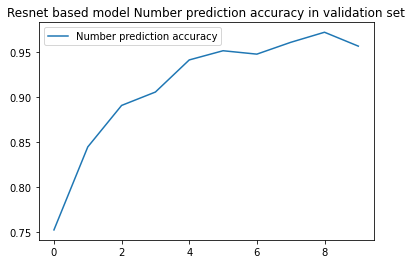

In [ ]:
plt.plot(number_acc_history,label="Number prediction accuracy")
plt.legend()
plt.title("Resnet based model Number prediction accuracy in validation set")

### Gender classification model resnet


In [ ]:
resnet = models.resnet34(pretrained=True)
class ModifiedResNetGender(nn.Module):
            def __init__(self):
                super(ModifiedResNetGender, self).__init__()
                self.features = nn.Sequential(
                    #remove last fully connected layer
                    *list(resnet.children())[:-1]
                )
                self.dense1 = nn.Linear(512,128)
                self.dense_gender = nn.Linear(128,1)
            def forward(self, x):
              # input shape = batch_size,n_channels,height,width
                x = self.features(x) # output shape = batch_size * 512 * 1 * 1
                x = x.view(-1,512)
                x = nn.ReLU()(self.dense1(x)) # ouput shape = batch_size * 128
                gender_pred = nn.Sigmoid()(self.dense_gender(x))

                return gender_pred

In [ ]:
model = ModifiedResNetGender()
model = model.to(device)

In [ ]:
# Binary-cross entropy loss, closely related to logistic regression loss
gender_obj_fn = nn.BCELoss()

#
number_obj_fn = nn.CrossEntropyLoss()

# Adam Optimizer, learning rate 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.)

In [ ]:
best_model_path = None
best_gender_model_path = "/content/drive/MyDrive/Deep_learning_music_project/best_model_gender_gender_recognition"
best_number_model_path = None

In [ ]:
training_loss_history,val_number_acc_history,val_gender_acc_history,val_loss_history = train(best_model_path=best_model_path,best_number_model_path=best_number_model_path,best_gender_model_path=best_gender_model_path,include_number= False)

Training starting ... 

Epoch number 1 --------------------------------------------------
 Average total loss = 0.07563325762748718 
 Average number prediction loss = 0.0 
 Average gender prediction loss = 0.07563325762748718 
performing validation ----------------------------------------
 number accuracy = 0.0 
 gender accuracy = 0.8758888840675354 
 Average val  loss = 0.06123822182416916 
Saving best gender prediction model
Epoch number 2 --------------------------------------------------
 Average total loss = 0.053547076880931854 
 Average number prediction loss = 0.0 
 Average gender prediction loss = 0.053547076880931854 
performing validation ----------------------------------------
 number accuracy = 0.0 
 gender accuracy = 0.9138888716697693 
 Average val  loss = 0.04463567957282066 
Saving best gender prediction model
Epoch number 3 --------------------------------------------------
 Average total loss = 0.040886733680963516 
 Average number prediction loss = 0.0 
 Average ge

In [ ]:
training_loss_history = [0.07563325762748718 , 0.053547076880931854 , 0.040886733680963516 ,0.029096048325300217 , 0.021964790299534798  , 0.01746850274503231 , 0.014299941249191761  , 0.012080764397978783 , 0.010405928827822208 , 0.008617249317467213 ]
gender_acc_history = [0.8758888840675354, 0.9138888716697693 , 0.9416666626930237 , 0.948888897895813  , 0.9610000252723694 , 0.9547777771949768 , 0.973111093044281 , 0.9605555534362793 , 0.976111114025116 , 0.9803333282470703 ]
val_loss_history = [0.06123822182416916 , 0.04463567957282066 ,0.031125614419579506 ,0.028415938839316368   , 0.02219352498650551 , 0.024307046085596085 , 0.014485271647572517 , 0.020392168313264847 , 0.013267816044390202 , 0.010446999222040176  ]


Text(0.5, 1.0, 'Resnet based model training and validation loss (gender prediction)')

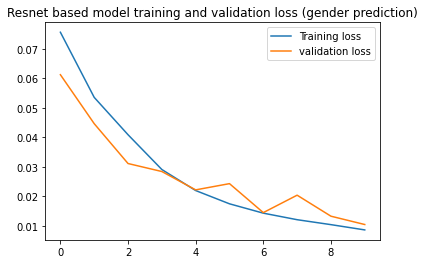

In [ ]:
plt.plot(training_loss_history,label="Training loss")
plt.plot(val_loss_history,label = "validation loss")
plt.legend()
plt.title("Resnet based model training and validation loss (gender prediction)")

Text(0.5, 1.0, 'Resnet based model Gender prediction accuracy in validation set')

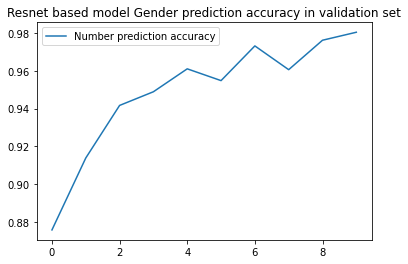

In [ ]:
plt.plot(gender_acc_history,label="Number prediction accuracy")
plt.legend()
plt.title("Resnet based model Gender prediction accuracy in validation set")

### Multitask model custom

In [ ]:
class customMultiModel(nn.Module):
            def __init__(self):
                super(customMultiModel, self).__init__()
                ##
                self.conv1 = nn.Conv2d(3,64,(3,3),stride=(2,2),padding=(3,3))
                self.BatchNorm1 = nn.BatchNorm2d(64,eps=0.00001,momentum=0.1,affine=True,track_running_stats=True)
                self.MaxPool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
                ##
                ##
                self.conv2 = nn.Conv2d(64,64,(3,3),stride=(2,2),padding=(3,3))
                self.BatchNorm2 = nn.BatchNorm2d(64,eps=0.00001,momentum=0.1,affine=True,track_running_stats=True)
                self.MaxPool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
                ##
                ##
                self.conv3 = nn.Conv2d(64,128,(7,7),stride=(2,2),padding=(3,3))
                self.BatchNorm3 = nn.BatchNorm2d(128,eps=0.00001,momentum=0.1,affine=True,track_running_stats=True)
                self.MaxPool3 = nn.MaxPool2d(kernel_size=5, stride=2, padding=1, dilation=1, ceil_mode=False)
                ##
                ##
                self.conv4 = nn.Conv2d(128,256,(3,3))
                ##
                ##
                self.dense_number = nn.Linear(256,10)
                self.dense_gender = nn.Linear(256,1)
            def forward(self, x):
              # input shape = batch_size,n_channels,height,width
              ##
              x = self.conv1(x)
              x = self.BatchNorm1(x)
              x = nn.ReLU()(x)
              x = self.MaxPool1(x)
              ##
              ##
              x = self.conv2(x)
              x = self.BatchNorm2(x)
              x = nn.ReLU()(x)
              x = self.MaxPool2(x)
              ##
              ##
              x = self.conv3(x)
              x = self.BatchNorm3(x)
              x = nn.ReLU()(x)
              x = self.MaxPool3(x)
              ##
              x = self.conv4(x)
              x = nn.ReLU()(x)
              ##
              x = x.view(-1,256)
              ##
              number_pred = nn.Softmax()(self.dense_number(x))
              gender_pred = nn.Sigmoid()(self.dense_gender(x))

              return [number_pred,gender_pred]


In [ ]:
model = customMultiModel()
model = model.to(device)


In [ ]:
summary(model, (3, 224, 224),batch_size=5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [5, 64, 114, 114]           1,792
       BatchNorm2d-2          [5, 64, 114, 114]             128
         MaxPool2d-3            [5, 64, 57, 57]               0
            Conv2d-4            [5, 64, 31, 31]          36,928
       BatchNorm2d-5            [5, 64, 31, 31]             128
         MaxPool2d-6            [5, 64, 16, 16]               0
            Conv2d-7             [5, 128, 8, 8]         401,536
       BatchNorm2d-8             [5, 128, 8, 8]             256
         MaxPool2d-9             [5, 128, 3, 3]               0
           Conv2d-10             [5, 256, 1, 1]         295,168
           Linear-11                    [5, 10]           2,570
           Linear-12                     [5, 1]             257
Total params: 738,763
Trainable params: 738,763
Non-trainable params: 0
-------------------------------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

738763

In [ ]:
# Binary-cross entropy loss, closely related to logistic regression loss
gender_obj_fn = nn.BCELoss()

#
number_obj_fn = nn.CrossEntropyLoss()

# Adam Optimizer, learning rate 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.)

In [ ]:
best_model_path = "/content/drive/MyDrive/Deep_learning_music_project/custom_model_both_number_gender"
best_gender_model_path = "/content/drive/MyDrive/Deep_learning_music_project/custom_model_gender_number_gender"
best_number_model_path = "/content/drive/MyDrive/Deep_learning_music_project/custom_model_number_number_gender"

In [ ]:
training_loss_history,val_number_acc_history,val_gender_acc_history,val_loss_history = train(best_model_path=best_model_path,best_number_model_path=best_number_model_path,best_gender_model_path=best_gender_model_path)

Training starting ... 

Epoch number 1 --------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 Average total loss = 0.40311506390571594 
 Average number prediction loss = 0.3504328727722168 
 Average gender prediction loss = 0.05268217995762825 
performing validation ----------------------------------------
 number accuracy = 0.9487777948379517 
 gender accuracy = 0.9297778010368347 
 Average val  loss = 0.3375683128833771 
Saving best model (for both tasks)
Epoch number 2 --------------------------------------------------
 Average total loss = 0.3280286192893982 
 Average number prediction loss = 0.30222105979919434 
 Average gender prediction loss = 0.025807546451687813 
performing validation ----------------------------------------
 number accuracy = 0.9769999980926514 
 gender accuracy = 0.9672222137451172 
 Average val  loss = 0.3134550154209137 
Saving best model (for both tasks)
Epoch number 3 --------------------------------------------------
 Average total loss = 0.317873477935791 
 Average number prediction loss = 0.29928457736968994 
 Average gender prediction loss =

In [ ]:
training_loss_history = [0.40311506390571594 ,0.3280286192893982,0.317873477935791,0.31148403882980347,0.30838072299957275 ,0.3054501712322235 , 0.30374056100845337 ,0.30148085951805115 ,0.300230473279953 ,0.29931193590164185    ]
number_acc_history = [0.9487777948379517,0.9769999980926514,0.9711111187934875,0.9732222557067871,0.9753333330154419 , 0.9846667051315308 ,0.9894444346427917 ,0.9801111221313477  ,0.9811111092567444 ,0.9885555505752563   ]
gender_acc_history = [0.9297778010368347, 0.9672222137451172,0.9503333568572998,0.9743333458900452,0.9822222590446472 , 0.9779999852180481 , 0.9783333539962769  ,0.9825555682182312 ,0.9787777662277222 ,0.9811111092567444  ]
val_loss_history = [0.3375683128833771, 0.3134550154209137,0.32704854011535645,0.3113786578178406,0.30717605352401733 , 0.30733609199523926 , 0.30687618255615234  ,0.30678755044937134 ,0.31110474467277527 ,0.30714237689971924  ]


Text(0.5, 1.0, 'CNN model training and validation loss (multitask)')

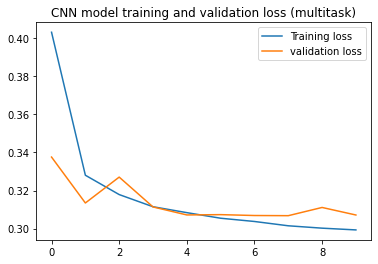

In [ ]:
plt.plot(training_loss_history,label="Training loss")
plt.plot(val_loss_history,label = "validation loss")
plt.legend()
plt.title("CNN model training and validation loss (multitask)")

Text(0.5, 1.0, 'CNN model Number and Gender prediction accuracy in validation set')

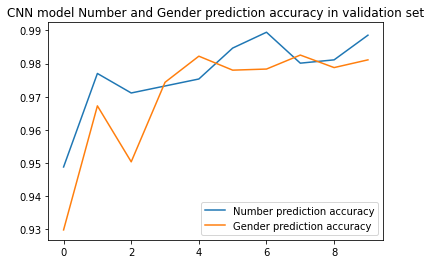

In [ ]:
plt.plot(number_acc_history,label="Number prediction accuracy")
plt.plot(gender_acc_history,label= "Gender prediction accuracy")
plt.legend()
plt.title("CNN model Number and Gender prediction accuracy in validation set")

### number classification model custom

In [ ]:
class customNumberModel(nn.Module):
            def __init__(self):
                super(customNumberModel, self).__init__()
                ##
                self.conv1 = nn.Conv2d(3,64,(3,3),stride=(2,2),padding=(3,3))
                self.BatchNorm1 = nn.BatchNorm2d(64,eps=0.00001,momentum=0.1,affine=True,track_running_stats=True)
                self.MaxPool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
                ##
                ##
                self.conv2 = nn.Conv2d(64,64,(3,3),stride=(2,2),padding=(3,3))
                self.BatchNorm2 = nn.BatchNorm2d(64,eps=0.00001,momentum=0.1,affine=True,track_running_stats=True)
                self.MaxPool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
                ##
                ##
                self.conv3 = nn.Conv2d(64,128,(7,7),stride=(2,2),padding=(3,3))
                self.BatchNorm3 = nn.BatchNorm2d(128,eps=0.00001,momentum=0.1,affine=True,track_running_stats=True)
                self.MaxPool3 = nn.MaxPool2d(kernel_size=5, stride=2, padding=1, dilation=1, ceil_mode=False)
                ##
                ##
                self.conv4 = nn.Conv2d(128,256,(3,3))
                ##
                ##
                self.dense1 = nn.Linear(256,10)
            def forward(self, x):
              # input shape = batch_size,n_channels,height,width
              ##
              x = self.conv1(x)
              x = self.BatchNorm1(x)
              x = nn.ReLU()(x)
              x = self.MaxPool1(x)
              ##
              ##
              x = self.conv2(x)
              x = self.BatchNorm2(x)
              x = nn.ReLU()(x)
              x = self.MaxPool2(x)
              ##
              ##
              x = self.conv3(x)
              x = self.BatchNorm3(x)
              x = nn.ReLU()(x)
              x = self.MaxPool3(x)
              ##
              x = self.conv4(x)
              x = nn.ReLU()(x)
              ##
              x = x.view(-1,256)
              ##
              x = self.dense1(x)
              x = nn.Softmax()(x)
              return x

In [ ]:
model = customNumberModel()
model = model.to(device)


In [ ]:
summary(model, (3, 224, 224),batch_size=5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [5, 64, 114, 114]           1,792
       BatchNorm2d-2          [5, 64, 114, 114]             128
         MaxPool2d-3            [5, 64, 57, 57]               0
            Conv2d-4            [5, 64, 31, 31]          36,928
       BatchNorm2d-5            [5, 64, 31, 31]             128
         MaxPool2d-6            [5, 64, 16, 16]               0
            Conv2d-7             [5, 128, 8, 8]         401,536
       BatchNorm2d-8             [5, 128, 8, 8]             256
         MaxPool2d-9             [5, 128, 3, 3]               0
           Conv2d-10             [5, 256, 1, 1]         295,168
           Linear-11                    [5, 10]           2,570
Total params: 738,506
Trainable params: 738,506
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.87
Forward/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
# Binary-cross entropy loss, closely related to logistic regression loss
gender_obj_fn = nn.BCELoss()

#
number_obj_fn = nn.CrossEntropyLoss()

# Adam Optimizer, learning rate 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.)

In [ ]:
best_model_path = None
best_gender_model_path = None
best_number_model_path = "/content/drive/MyDrive/Deep_learning_music_project/custom_model_number"

In [ ]:
training_loss_history,val_number_acc_history,val_gender_acc_history,val_loss_history = train(best_model_path=best_model_path,best_number_model_path=best_number_model_path,best_gender_model_path=best_gender_model_path,include_gender= False)

Training starting ... 

Epoch number 1 --------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 Average total loss = 0.3887791037559509 
 Average number prediction loss = 0.3887791037559509 
 Average gender prediction loss = 0.0 
performing validation ----------------------------------------
 number accuracy = 0.890333354473114 
 gender accuracy = 0.0 
 Average val  loss = 0.31559184193611145 
Saving best Number prediction model
Epoch number 2 --------------------------------------------------
 Average total loss = 0.30429282784461975 
 Average number prediction loss = 0.30429282784461975 
 Average gender prediction loss = 0.0 
performing validation ----------------------------------------
 number accuracy = 0.9516666531562805 
 gender accuracy = 0.0 
 Average val  loss = 0.3021279275417328 
Saving best Number prediction model
Epoch number 3 --------------------------------------------------
 Average total loss = 0.3007502853870392 
 Average number prediction loss = 0.3007502853870392 
 Average gender prediction loss = 0.0 
performing validation ---------------------------------

In [ ]:
training_loss_history = [0.3887791037559509  , 0.30429282784461975 , 0.3007502853870392 , 0.29927492141723633 , 0.2980514168739319 , 0.29811525344848633 , 0.29675397276878357 , 0.29652640223503113 , 0.29697173833847046 , 0.2986651659011841  ]
number_acc_history = [0.890333354473114 , 0.9516666531562805  , 0.956000030040741 ,0.9174444675445557 ,0.9688888788223267 ,0.9681110978126526 , 0.972444474697113  , 0.9842222332954407 , 0.9677777886390686 , 0.9801111221313477  ]
val_loss_history = [0.31559184193611145  , 0.3021279275417328 , 0.3010355532169342 , 0.30886396765708923 ,0.298443078994751  , 0.29859617352485657 ,0.29767918586730957 , 0.29537874460220337  , 0.2986651659011841 , 0.29623734951019287  ]


Text(0.5, 1.0, 'CNN model training and validation loss')

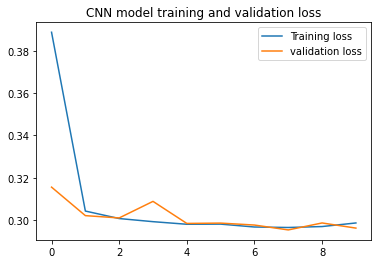

In [ ]:
plt.plot(training_loss_history,label="Training loss")
plt.plot(val_loss_history,label = "validation loss")
plt.legend()
plt.title("CNN model training and validation loss")

Text(0.5, 1.0, 'CNN model Number and Gender prediction accuracy in validation set')

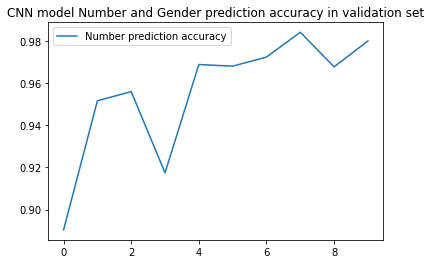

In [ ]:
plt.plot(number_acc_history,label="Number prediction accuracy")
plt.legend()
plt.title("CNN model Number and Gender prediction accuracy in validation set")

### gender classification model custom

In [ ]:
class customGenderModel(nn.Module):
            def __init__(self):
                super(customGenderModel, self).__init__()
                ##
                self.conv1 = nn.Conv2d(3,64,(3,3),stride=(2,2),padding=(3,3))
                self.BatchNorm1 = nn.BatchNorm2d(64,eps=0.00001,momentum=0.1,affine=True,track_running_stats=True)
                self.MaxPool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
                ##
                ##
                self.conv2 = nn.Conv2d(64,64,(3,3),stride=(2,2),padding=(3,3))
                self.BatchNorm2 = nn.BatchNorm2d(64,eps=0.00001,momentum=0.1,affine=True,track_running_stats=True)
                self.MaxPool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
                ##
                ##
                self.conv3 = nn.Conv2d(64,128,(7,7),stride=(2,2),padding=(3,3))
                self.BatchNorm3 = nn.BatchNorm2d(128,eps=0.00001,momentum=0.1,affine=True,track_running_stats=True)
                self.MaxPool3 = nn.MaxPool2d(kernel_size=5, stride=2, padding=1, dilation=1, ceil_mode=False)
                ##
                ##
                self.conv4 = nn.Conv2d(128,256,(3,3))
                ##
                ##
                self.dense1 = nn.Linear(256,1)
            def forward(self, x):
              # input shape = batch_size,n_channels,height,width
              ##
              x = self.conv1(x)
              x = self.BatchNorm1(x)
              x = nn.ReLU()(x)
              x = self.MaxPool1(x)
              ##
              ##
              x = self.conv2(x)
              x = self.BatchNorm2(x)
              x = nn.ReLU()(x)
              x = self.MaxPool2(x)
              ##
              ##
              x = self.conv3(x)
              x = self.BatchNorm3(x)
              x = nn.ReLU()(x)
              x = self.MaxPool3(x)
              ##
              x = self.conv4(x)
              x = nn.ReLU()(x)
              ##
              x = x.view(-1,256)
              ##
              x = self.dense1(x)
              x = nn.Sigmoid()(x)
              return x

In [ ]:
model = customGenderModel()
model = model.to(device)


In [ ]:
summary(model, (3, 224, 224),batch_size=5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [5, 64, 114, 114]           1,792
       BatchNorm2d-2          [5, 64, 114, 114]             128
         MaxPool2d-3            [5, 64, 57, 57]               0
            Conv2d-4            [5, 64, 31, 31]          36,928
       BatchNorm2d-5            [5, 64, 31, 31]             128
         MaxPool2d-6            [5, 64, 16, 16]               0
            Conv2d-7             [5, 128, 8, 8]         401,536
       BatchNorm2d-8             [5, 128, 8, 8]             256
         MaxPool2d-9             [5, 128, 3, 3]               0
           Conv2d-10             [5, 256, 1, 1]         295,168
           Linear-11                     [5, 1]             257
Total params: 736,193
Trainable params: 736,193
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.87
Forward/

In [ ]:
# Binary-cross entropy loss, closely related to logistic regression loss
gender_obj_fn = nn.BCELoss()

#
number_obj_fn = nn.CrossEntropyLoss()

# Adam Optimizer, learning rate 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.)

In [ ]:
best_model_path = None
best_gender_model_path = "/content/drive/MyDrive/Deep_learning_music_project/custom_model_gender"
best_number_model_path = None

In [ ]:
training_loss_history,val_number_acc_history,val_gender_acc_history,val_loss_history = train(best_model_path=best_model_path,best_number_model_path=best_number_model_path,best_gender_model_path=best_gender_model_path,include_number= False)

Training starting ... 

Epoch number 1 --------------------------------------------------
 Average total loss = 0.05341811850667 
 Average number prediction loss = 0.0 
 Average gender prediction loss = 0.05341811850667 
performing validation ----------------------------------------
 number accuracy = 0.0 
 gender accuracy = 0.9487777948379517 
 Average val  loss = 0.02727482095360756 
Saving best gender prediction model
Epoch number 2 --------------------------------------------------
 Average total loss = 0.02696439065039158 
 Average number prediction loss = 0.0 
 Average gender prediction loss = 0.02696439065039158 
performing validation ----------------------------------------
 number accuracy = 0.0 
 gender accuracy = 0.9230000376701355 
 Average val  loss = 0.04670552536845207 
Epoch number 3 --------------------------------------------------
 Average total loss = 0.01858622021973133 
 Average number prediction loss = 0.0 
 Average gender prediction loss = 0.01858622021973133 
p

In [ ]:
training_loss_history = [0.05341811850667 , 0.02696439065039158 , 0.01858622021973133 , 0.013552340678870678  , 0.01037200540304184 , 0.008464916609227657 , 0.006810968741774559  , 0.006089292466640472 , 0.005294088739901781  , 0.004306661430746317 ]
gender_acc_history = [0.9487777948379517 , 0.9230000376701355 , 0.9685555696487427, 0.9734444618225098 , 0.9634444713592529 , 0.9711111187934875 , 0.9791111350059509 , 0.9792222380638123 , 0.9803333282470703 , 0.9838889241218567 ]
val_loss_history = [0.02727482095360756 , 0.04670552536845207 , 0.01784481294453144 , 0.014942335896193981 , 0.02075936086475849 , 0.016368569806218147 , 0.011952199041843414  , 0.011762091889977455 , 0.01352416817098856 , 0.00990079902112484 ]


Text(0.5, 1.0, 'CNN model training and validation loss (gender prediction)')

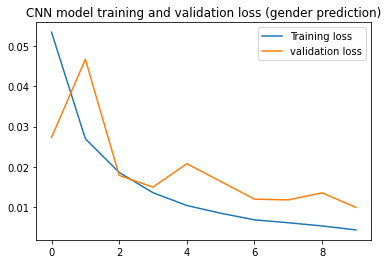

In [ ]:
plt.plot(training_loss_history,label="Training loss")
plt.plot(val_loss_history,label = "validation loss")
plt.legend()
plt.title("CNN model training and validation loss (gender prediction)")

Text(0.5, 1.0, 'CNN model Gender prediction accuracy in validation set')

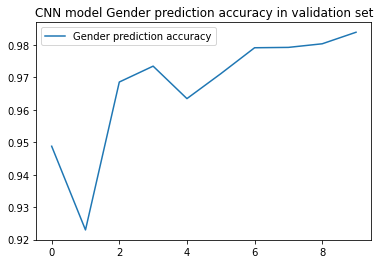

In [ ]:
plt.plot(gender_acc_history,label="Gender prediction accuracy")
plt.legend()
plt.title("CNN model Gender prediction accuracy in validation set")